# Sample Tweet Analysis

This notebook aims to classify the various given in the dataset as sarcastic or not. The tweets are not in English, hence it would be difficult to find pretrained embeddings for them. The dataset consists of 500 samples, with each sample only two columns:
- `sarcasm`: A boolean indicating whether the tweet was sarcastic or not
- `processed_tweet`: Content of the tweet after some processing, like removal of hashtags, tags and emojis. 

In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv("data/sample_tweets.csv", sep=',', names=['label', 'text'], header=0)

df.head()

,label,text
0,1,ka bhagwan bar ka ram lakh lakh pe shukra hai ...
1,0,Triple talaq illegal ho gaya hai .
2,0,Tum Ka Triple Talaq Halala ke Alawa kuch nahi ...
3,1,bol the dialogue :'tu aik ek insaan pakistan k...
4,0,bhai aap ki karachi say kia dushmani hay ? saa...


In [2]:
from sklearn.model_selection import train_test_split

tweets = df["text"].values
y = df["label"].values

# Divide into a 25% test set and 75% training set
tweets_train, tweets_test, y_train, y_test = train_test_split(
    tweets, y, test_size=0.25, random_state=1000
)

print("Training set length: ", len(tweets_train))
print("Test set length: ", len(tweets_test))

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Training set length:  375
Test set length:  125


In [3]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")

# Create a charitng utility to plot the graphs for accuracy and loss
def plot_history(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, "b", label="Training acc")
    plt.plot(x, val_acc, "r", label="Validation acc")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, "b", label="Training loss")
    plt.plot(x, val_loss, "r", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()

## Model 1: Count Vectorization + Neural Network

We will use a simple `Bag of Words` encoding to convert the sentences to a vocabulary, and then embed each sentence where each index represents the frequency of the word in that sentence for the word at that index in the vocabulary. BOW is used to represent the sequence of words (sentence) as single feature vector. We will use a linear-regression model to classify the same. 

- `CountVectorizer` performs tokenization which separates the sentences into a set of tokens as you saw previously in the vocabulary. It additionally removes punctuation and special characters.
- We made use of a simple Neural Network with one dense layer of `10` neurons, and one output neuron. 

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.models import Sequential
from keras import layers

# Use CountVectorizer to convert the text tweets to vectors of word counts
vectorizer = CountVectorizer()
vectorizer.fit(tweets_train)

X_train = vectorizer.transform(tweets_train)
X_test = vectorizer.transform(tweets_test)

input_dim = X_train.shape[1]  # Size of the vocabulary

# Build a simple Neural Network with only two layers
model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

2023-12-23 17:02:06.405159: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-23 17:02:06.407371: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-23 17:02:06.434234: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-23 17:02:06.434267: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-23 17:02:06.435276: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                26330     
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 26341 (102.89 KB)
Trainable params: 26341 (102.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Training Accuracy: 100.0000%
Testing Accuracy:  93.6000%


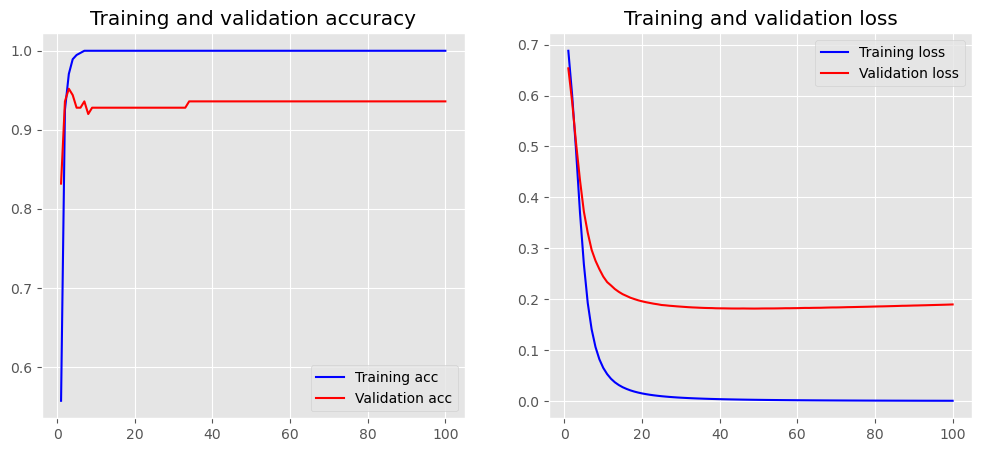

In [5]:
# Train the model and plot the accuracy and loss graphs
from keras.backend import clear_session

# Clear any previous data from the session
clear_session()

history = model.fit(
    X_train,
    y_train,
    epochs=100,
    verbose=False,
    validation_data=(X_test, y_test),
    batch_size=10,
)

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}%".format(accuracy*100))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}%".format(accuracy*100))

plot_history(history)

### Model 2: Neural Network with Simple Index-based Embedding

For embedding in this case, we use `Kera's Tokenizer`, which first calculates the vocabulary as the distinct words in all the training sentences, and then assigns each one of them an index used to identify them. Then each sentence is converted to an array of indexes to represent it. To ensure the dimensions of each sentence are the same, we manually define the `maxlen` parameter and then pad the arrays accordingly. 

- Since we do not have any pretrained embeddings for these words, we create random embeddings into 50 dimensions for each of the words and allow the model to train them during the learning process. 
- We use the same architecture as the previous model, but with an additional `Embedding` and `Flatten` layer.
- We do not use any pooling layers as we don't have a long context available to us. 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           133650    
                                                                 
 flatten (Flatten)           (None, 5000)              0         
                                                                 
 dense (Dense)               (None, 10)                50010     
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 183671 (717.46 KB)
Trainable params: 183671 (717.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Training Accuracy: 1.0000
Testing Accuracy:  0.8960


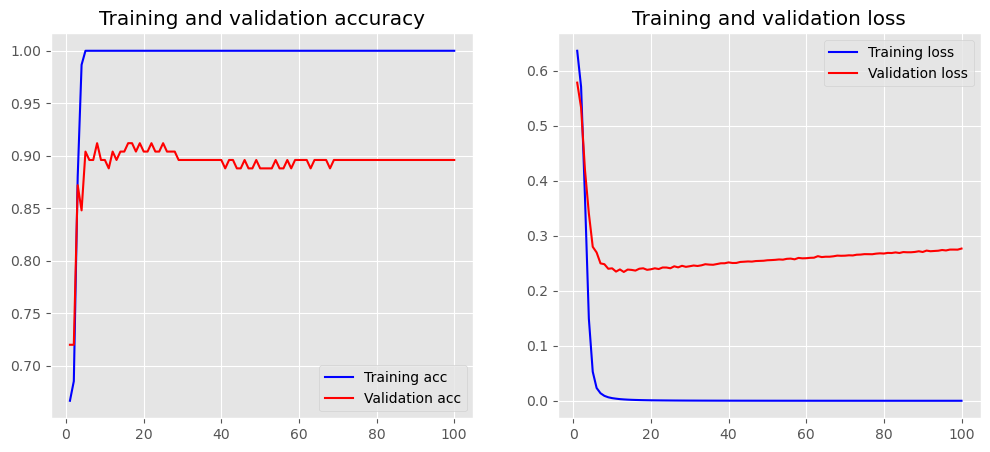

In [6]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers

tokenizer = Tokenizer(num_words=2500)
tokenizer.fit_on_texts(tweets_train)

X_train = tokenizer.texts_to_sequences(tweets_train)
X_test = tokenizer.texts_to_sequences(tweets_test)

vocab_size = (
    len(tokenizer.word_index) + 1
)  # Adding 1 because of reserved 0 index for padding


maxlen = 100
X_train = pad_sequences(X_train, padding="post", maxlen=maxlen)
X_test = pad_sequences(X_test, padding="post", maxlen=maxlen)

embedding_dim = 50

model = Sequential()
# input_dim is the size of the vocabulary
# input_length is the length of the input sequences (maxlen)
model.add(
    layers.Embedding(
        input_dim=vocab_size, 
        output_dim=embedding_dim, 
        input_length=maxlen, 
        trainable=True
    )
)
# We need to add a Flatten layer to flatten the 2D matrix into a 1D vector
model.add(layers.Flatten())
model.add(layers.Dense(10, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

history = model.fit(
    X_train,
    y_train,
    epochs=100,
    verbose=False,
    validation_data=(X_test, y_test),
    batch_size=10,
)

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_history(history)

It can be seen that this model doesn not perform better than the previous model. The primary reason of the same can be the limited size of the dataset that is provided to us. In the absence of pretrained embeddings, the model doesn't have enough contextual information to meaning generate the new embeddings and process them.

## Model 3: Recurrent Neural Networks and LTSMs

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.models import Sequential
from keras import layers

# Use CountVectorizer to convert the text tweets to vectors of word counts
vectorizer = CountVectorizer()
vectorizer.fit(tweets_train)

X_train = vectorizer.transform(tweets_train)
X_test = vectorizer.transform(tweets_test)

input_dim = X_train.shape[1]  # Size of the vocabulary

# Build a simple Neural Network with only two layers
model = Sequential()
model.add(layers.SimpleRNN(10, input_dim=input_dim, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()


history = model.fit(
    X_train,
    y_train,
    epochs=100,
    verbose=False,
    validation_data=(X_test, y_test),
    batch_size=10,
)

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_history(history)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10)                26430     
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 26441 (103.29 KB)
Trainable params: 26441 (103.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


ValueError: in user code:

    File "/home/eshaan/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/home/eshaan/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/eshaan/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/home/eshaan/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/home/eshaan/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/eshaan/.local/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 235, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_1' (type Sequential).
    
    Input 0 of layer "simple_rnn" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 2632)
    
    Call arguments received by layer 'sequential_1' (type Sequential):
      • inputs=SparseTensor(indices=Tensor("DeserializeSparse:0", shape=(None, 2), dtype=int64), values=Tensor("DeserializeSparse:1", shape=(None,), dtype=int64), dense_shape=Tensor("stack:0", shape=(2,), dtype=int64))
      • training=True
      • mask=None


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           128750    
                                                                 
 flatten (Flatten)           (None, 5000)              0         
                                                                 
 dense (Dense)               (None, 10)                50010     
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 178771 (698.32 KB)
Trainable params: 178771 (698.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Training Accuracy: 1.0000
Testing Accuracy:  0.6524


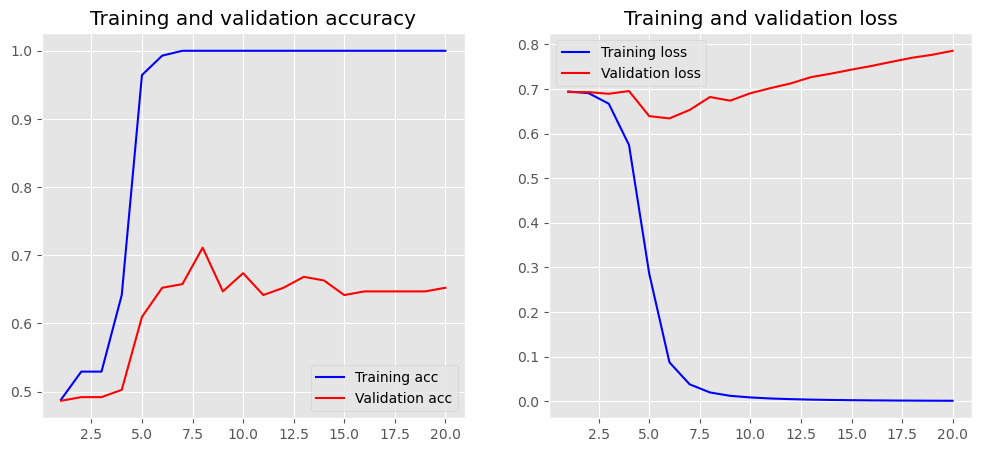

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 50)           128750    
                                                                 
 global_max_pooling1d (Glob  (None, 50)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_2 (Dense)             (None, 10)                510       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 129271 (504.96 KB)
Trainable params: 129271 (504.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Training Accuracy: 1.0000
Testing Accuracy:  0.8182


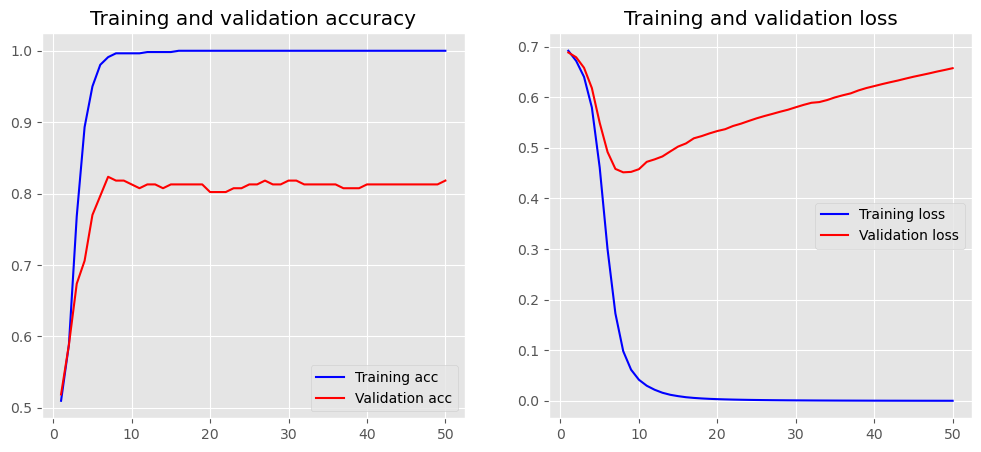

In [ ]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(
    layers.Embedding(
        input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen
    )
)
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

history = model.fit(
    X_train,
    y_train,
    epochs=50,
    verbose=False,
    validation_data=(X_test, y_test),
    batch_size=10,
)

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_history(history)

### GloVe Word Embedding

We now explore the alternative to use a precomputed embedding space that utilizes a much larger corpus. It is possible to precompute word embeddings by simply training them on a large corpus of text. We would be using `GloVe` (Global Vectors for Word Representation) developed by the `Stanford NLP Group`.

GloVe achieves embedding with a co-occurrence matrix and by using matrix factorization. I have used the `50 dimensional word embedding` by GloVe trained on a dataset of `6 billion words` which can be downloaded from [here](https://nlp.stanford.edu/projects/glove/).

Percentage of words convered by the embedding: 95.22330097087378
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 50)           128750    
                                                                 
 global_max_pooling1d_1 (Gl  (None, 50)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_4 (Dense)             (None, 10)                510       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 129271 (504.96 KB)
Trainable params: 521 (2.04 KB)
Non-trainable params: 128750 (502.93 KB)
_________________________________________________________________
Training Accura

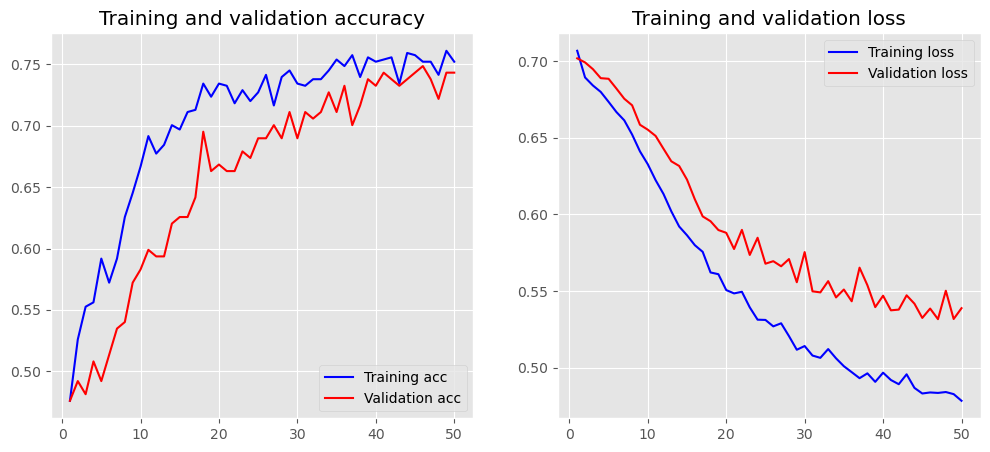

In [ ]:
import numpy as np


# A helper function which reads the file from `filepath` and creates an embedding matrix of `embedding_dim` with only the words in `word_index`
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[
                    :embedding_dim
                ]

    return embedding_matrix


# Create the embedding matrix using GloVe 50-dimension embedding
embedding_dim = 50
embedding_matrix = create_embedding_matrix(
    "data/embedding/glove.6B.50d.txt", tokenizer.word_index, embedding_dim
)

# Calculate the percentage of words that are covered by the GloVe embedding
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print(f"Percentage of words convered by the embedding: {100 * nonzero_elements / vocab_size}")

# Create, train and evaluate the model
model = Sequential()
model.add(
    layers.Embedding(
        vocab_size,
        embedding_dim,
        weights=[embedding_matrix],
        input_length=maxlen,
        trainable=False,
    )
)
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

history = model.fit(
    X_train,
    y_train,
    epochs=50,
    verbose=False,
    validation_data=(X_test, y_test),
    batch_size=10,
)

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_history(history)